<a href="https://colab.research.google.com/github/sarahdell/DSPS_SDellorco/blob/main/Lab/Dellorco_DSPS2023_transformer_sn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical

!pip install icecream
from icecream import ic

# Read in data

In [2]:
df_raw = pd.read_parquet("https://github.com/FoxFortino/SCS/raw/main/data/raw/sn_data.parquet")

In [3]:
df_raw #in spectral phase, 0 is peak brightness. Other columns with numbers are wavelengths for title and the values in each column is flux values given the wavelength

,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,2515.28,...,9872.21,9885.59,9898.98,9912.39,9925.82,9939.27,9952.73,9966.21,9979.71,9993.24
SN Name,,,,,,,,,,,,,,,,,,,,,
sn2008ar,Ia-norm,0,Ia,0,-8.50,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sn2008ar,Ia-norm,0,Ia,0,-7.50,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sn2008ar,Ia-norm,0,Ia,0,-6.60,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sn2008ar,Ia-norm,0,Ia,0,-4.60,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sn2008ar,Ia-norm,0,Ia,0,-3.70,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sn2007uy,Ib-pec,9,Ib,1,12.82,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sn2007uy,Ib-pec,9,Ib,1,45.82,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sn2007uy,Ib-pec,9,Ib,1,54.82,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
def extract_dataframe(sn_data):
    """
    Extract both metadata and flux data from a dataframe.
    """
    # Extract the row indices from the dataframe. These correspond to the SN
    # name of the spectrum at each row.
    index = sn_data.index

    # Extract the sub-dataframe that contains only the columns corresponding
    # to flux values. We do this specifically with a regex expression that
    # takes only the columns that start with a number.
    df_fluxes = sn_data.filter(regex="\d+")
    fluxes = df_fluxes.to_numpy(dtype=float)

    # Extract the columns that identify the flux columns. These will also be
    # the wavelengths at for each flux value, but as a string.
    flux_columns = df_fluxes.columns
    wvl = flux_columns.to_numpy(dtype=float)

    # In the eveny that more non-flux columns are added to these dataframes, we
    # find all of the columns representing the metadata (such as SN class,
    # spectral phase, etc.) by extracting all columns apart from
    # `flux_columns`.
    metadata_columns = sn_data.columns.difference(flux_columns)
    df_metadata = sn_data[metadata_columns]

    return (index, wvl,
            flux_columns, metadata_columns,
            df_fluxes, df_metadata,
            fluxes)

index, wvl, flux_columns, metadata_columns, df_fluxes, df_metadata, fluxes = extract_dataframe(df_raw)

# Visualize data

In [5]:
@np.vectorize
def wavelen2rgb(nm):
    """
    Converts a wavelength between 380 and 780 nm to an RGB color tuple.

    Willow: This code taken from rsmith-nl/wavelength_to_rgb git repo.

    Arguments
    ---------
        nm : float
            Wavelength in nanometers.
    Returns
    -------
        rgb : 3-tuple
            tuple (red, green, blue) of integers in the range 0-255.
    """

    def adjust(color, factor):
        if color < 0.01:
            return 0
        max_intensity = 255
        gamma = 0.80
        rv = int(round(max_intensity * (color * factor) ** gamma))
        if rv < 0:
            return 0
        if rv > max_intensity:
            return max_intensity
        return rv

    # if nm < 380 or nm > 780:
    #     raise ValueError('wavelength out of range')
    if nm < 380:
        nm = 380
    if nm > 780:
        nm = 780

    red = 0.0
    green = 0.0
    blue = 0.0
    # Calculate intensities in the different wavelength bands.
    if nm < 440:
        red = -(nm - 440.0) / (440.0 - 380.0)
        blue = 1.0
    elif nm < 490:
        green = (nm - 440.0) / (490.0 - 440.0)
        blue = 1.0
    elif nm < 510:
        green = 1.0
        blue = -(nm - 510.0) / (510.0 - 490.0)
    elif nm < 580:
        red = (nm - 510.0) / (580.0 - 510.0)
        green = 1.0
    elif nm < 645:
        red = 1.0
        green = -(nm - 645.0) / (645.0 - 580.0)
    else:
        red = 1.0
    # Let the intensity fall off near the vision limits.
    if nm < 420:
        factor = 0.3 + 0.7 * (nm - 380.0) / (420.0 - 380.0)
    elif nm < 701:
        factor = 1.0
    else:
        factor = 0.3 + 0.7 * (780.0 - nm) / (780.0 - 700.0)
    # Return the calculated values in an (R,G,B) tuple.
    return (adjust(red, factor), adjust(green, factor), adjust(blue, factor))


def adjust_logbins(bins, current="center", new="leftedge"):
    """
    Redefines whether an array corresponds to bin centers or bin edges.

    Assuming the bins have a constant spacing in log-space (that is:
    ``np.diff(np.log(bins))`` is a constant array) then this function will
    shift the bins from bin-center-defined to bin-edge-defined or vice versa.

    Arguments
    ---------
    bins : array-like
        One dimensional array of bin positions.
    current : {"center", "leftedge",}, default: "center"
        Whether the bins array currently defines the bin centers or left edge.
    new : {"center", "leftedge"}, default: "leftedge"
        What the returned bins array should define: the bin centers or the left
        bin edge.

    Returns
    -------
    new_bins : array-like
        One dimensional array of new bin positions.
    """

    logbin = np.log(bins)
    d_logbin = np.mean(np.diff(logbin))

    if current == "center" and new == "leftedge":
        # diff_logbin / 2 will give the bin radius in log space. If our array
        # denotes bin-centers, then we need to subtract the bin radius from
        # the array so that now the array is denoting left-bin-edges.
        # Also note we need to add one more bin in log space before we take
        # np.diff. This is so that when we subtract arrays of the same shape
        # in the next line.
        bin_radii = np.diff(logbin, append=logbin[-1] + d_logbin)
        new_logbins = logbin - bin_radii * 0.5
        new_bins = np.exp(new_logbins)

    elif current == "leftedge" and new == "center":
        bin_widths = np.diff(logbin, append=logbin[-1] + d_logbin)
        new_logbins = logbin + bin_widths * 0.5
        new_bins = np.exp(new_logbins)

    return new_bins


def plot_spec(ax, wvl, flux):
    """
    Plot a spectrum with appropriate colors.

    Arguments
    ---------
    wvl : (N,) array-like
        Array defining the wavelength bin centers of the spectrograph.
    flux : (N,) array-like
        Array of flux values for each wavelength bin.
    """

    if not np.any(wvl > 7000):
        RGB = wavelen2rgb(wvl / 10)
        RGBA = np.array(RGB).T / 255
    else:
        # If there are wavelength points above 7000 angstroms, make them an
        # RGB value corresponding to 7000 angstroms. This RGB code can't
        # handle wavelengths not between 4000 and 7000 angstroms.
        over7000 = np.where(wvl > 7000)[0]
        wvl_copy = wvl.copy()
        wvl_copy[over7000] = 7000
        RGB = wavelen2rgb(wvl_copy / 10)
        RGBA = np.array(RGB).T / 255

    errmsg = (
        "flux and wvl arrays should be of same size but are "
        f"{flux.size} and {wvl.size} respectively. Each flux value "
        "should correspond to one wavelength bin. See docstring for "
        "more info."
    )
    assert wvl.size == flux.size, errmsg

    wvl_LE = adjust_logbins(wvl)

    ax.plot(
        wvl[:-1],
        flux[:-1],
        ls="",
        c="k",
        marker="",
        )
    _, _, patches = ax.hist(
        wvl_LE[:-1],
        bins=wvl_LE,
        weights=flux[:-1],
        align="mid",
        )

    # Each patch of the histogram (the rectangle underneath each point) gets
    # colored according to its central wavelength.
    for patch, color in zip(patches, RGBA):
        patch.set_facecolor(color)

    ax.set_xlabel(r"Wavelength [$\AA$]")
    ax.set_ylabel(r"Normalized Flux [$F_{\lambda}$]")

    # bounds = flux.max() + flux.max()*0.05
    # ax.ylim((-bounds, bounds))

    ax.set_ylim((0, 1.05))

    ax.set_ylim((flux.min(), flux.max()))
    ax.set_xlim((3800, 7000))

    ax.tick_params(axis="both", which="major")

    return ax

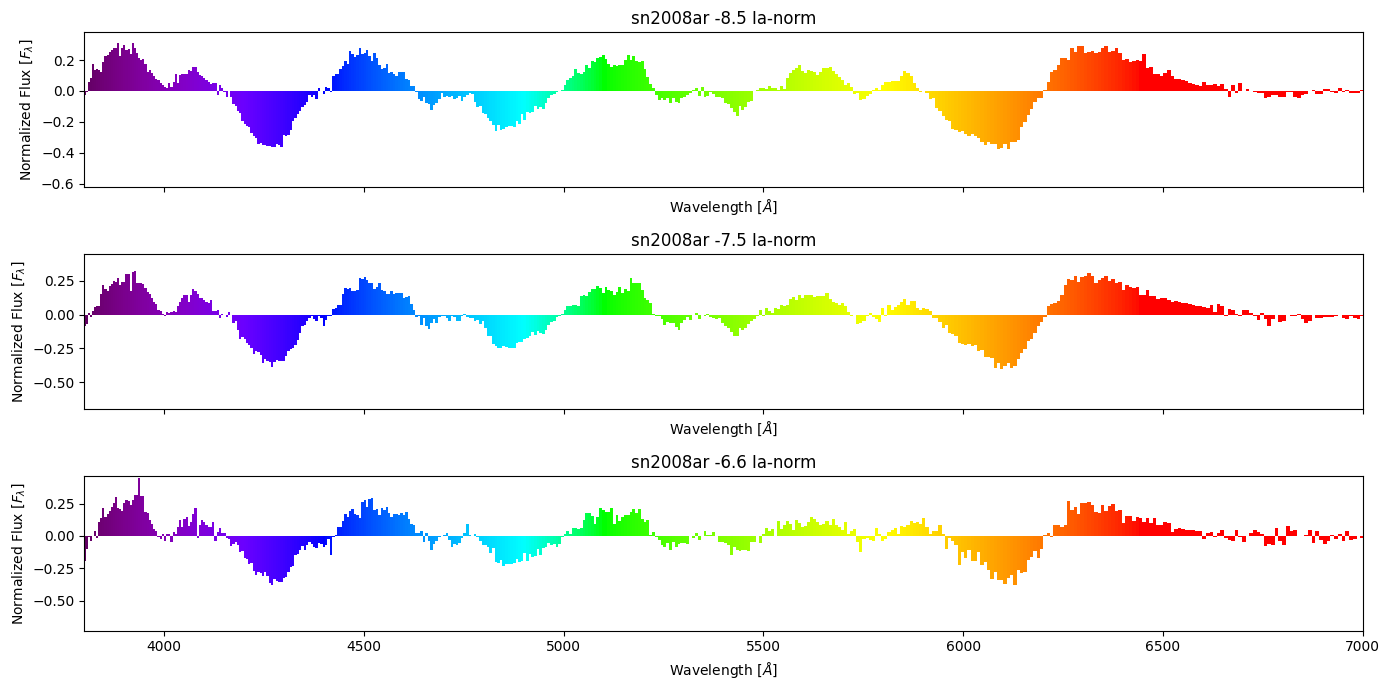

In [6]:
def plot_multiple_specs(df, nrows, offset):
  index, wvl, flux_columns, metadata_columns, df_fluxes, df_metadata, fluxes = extract_dataframe(df) #wvl is wavelength value

  fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex=True, sharey=False, figsize=(14,7))

  for i in range(nrows):
    ax=axes.flatten()[i]

    flux=fluxes[i]
    sn=index[i] #name of supernova
    phase=df_metadata["Spectral Phase"].values[i]
    sntype = df_metadata["SN Subtype"].values[i]

    ax.set_title(f"{sn} {phase} {sntype}")
    ax=plot_spec(ax, wvl, flux)

  fig.tight_layout()
  return fig

fig = plot_multiple_specs(df_raw, 3, 2000)
fig.show()

# Data preprocessing

In [7]:
def preproccess_dataframe(
    sn_data,
    phase_range=(-20, 50), #20 days before or 50 days after peak brightness
    ptp_range=(0.1, 100), #peak to peak range
    wvl_range=(4500, 7000), #only accepting wavelengths in this range
    save_path=None,
):
    if (save_path is not None) and (not isdir(dirname(save_path))):
        raise FileNotFoundError(f"Directory '{dirname(save_path)}' does not exist.")

    # The function below neatly and reproducibly extracts all of the relevant
    # subsets of the dataframe.
    data = extract_dataframe(sn_data)
    index = data[0]  # SN Name for each spectrum
    wvl0 = data[1]  # Wavelength array
    flux0_columns = data[2]  # Columns that index the fluxes in the dataframe
    metadata_columns = data[3]  # Columns that index the metadata
    df_fluxes0 = data[4]  # Sub-dataframe containing only the fluxes
    df_metadata = data[5]  # Sub-dataframe containing only the metadata
    fluxes0 = data[6]  # Only the flux values in a numpy array

    # Spectra with a spectral phase outside of `phase_range`.
    bad_ind = sn_data["Spectral Phase"] < phase_range[0]
    bad_ind |= sn_data["Spectral Phase"] > phase_range[1]

    # Remove the spectra with a range that is too small or too large.
    ptp = np.ptp(fluxes0, axis=1)
    bad_ind |= ptp < ptp_range[0]
    bad_ind |= ptp > ptp_range[1]

    # Remove rows from fluxes0 according to bad_ind
    fluxes0 = fluxes0[~bad_ind]

    # Standardize the dataset to zero mean and standard deviation of 1.
    flux_means = np.mean(fluxes0, axis=1)[..., None]
    flux_stds = np.std(fluxes0, axis=1)[..., None]
    standardized_fluxes0 = (fluxes0 - flux_means) / flux_stds

    # Set all flux values outside of `wvl_range` to 0.
    standardized_fluxes0[:, (wvl0 < wvl_range[0]) | (wvl0 > wvl_range[1])] = 0

    # Set the standardized flux data into the dataframe.
    sn_data.loc[~bad_ind, flux0_columns] = standardized_fluxes0

    # Remove the rows that we have pruned above.
    sn_data = sn_data.loc[~bad_ind]

    if save_path is not None:
        sn_data.to_parquet(save_path)
        print(f"Saved: {save_path}")

    return sn_data

df_P = preproccess_dataframe(df_raw)

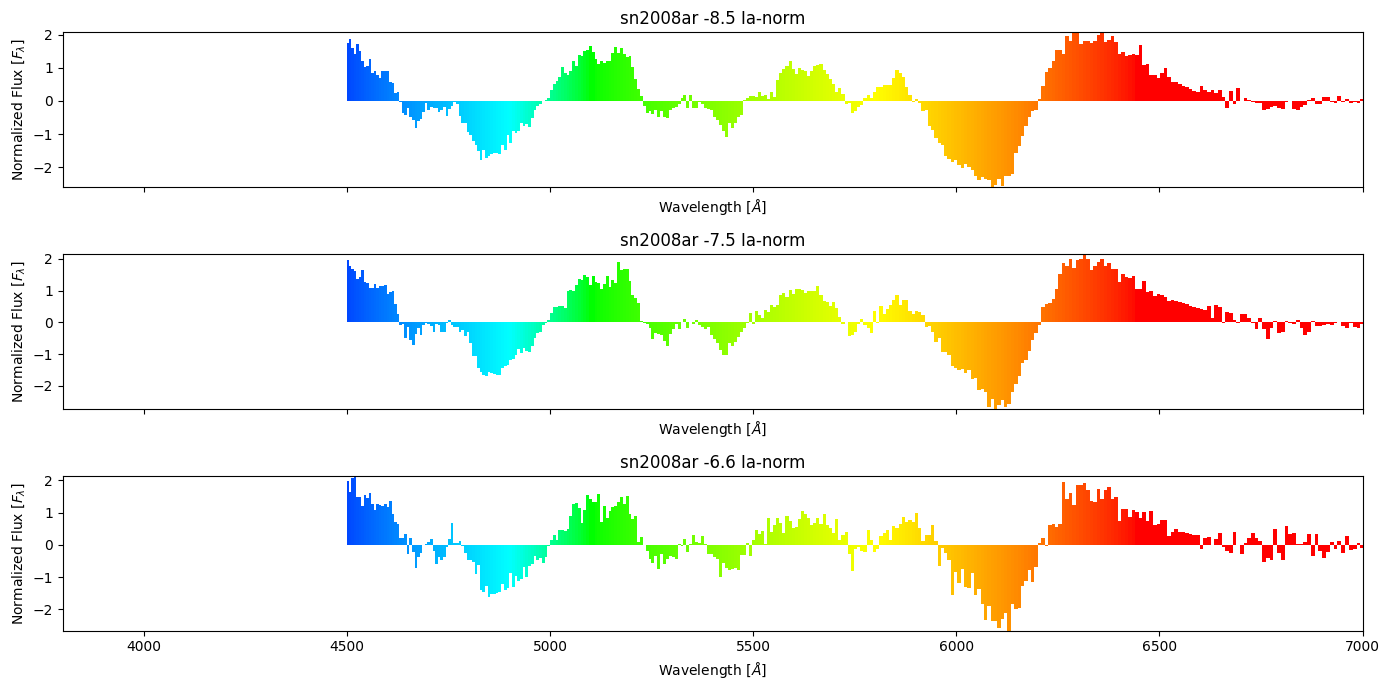

In [9]:
fig = plot_multiple_specs(df_P, 3, 2000)
fig.show()

# Train-test split...

How should we do this train-test split?

Trying to predict the supernova type for a spectra.

Train-test split each class separately since some classes are greatly represented and some are not.

Dataset contamination is an issue. Below we are using a 60% split.

In [10]:
def df_split(x, train_frac, rng):
    x["Exclude"] = False
    x["Training Set"] = False

    sn_names = x.index.unique().to_list()
    num_supernova = len(sn_names)
    if num_supernova == 1:
        x["Exclude"] = True
        return x

    num_train = int(np.ceil(num_supernova * train_frac))
    if num_supernova - num_train == 0:
        num_train -= 1

    inds = rng.choice(sn_names,
                      size=num_train,
                      replace=False)
    x.loc[inds, "Training Set"] = True
    return x


def split_data(
    sn_data,
    train_frac,
    rng,
    save_path_trn=None,
    save_path_tst=None,
):
    if (save_path_trn is not None) and (save_path_tst is not None):
        if not isdir(dirname(save_path_tst)):
            raise FileNotFoundError(f"Directory '{dirname(save_path_tst)}' does not exist.")
        if not isdir(dirname(save_path_trn)):
            raise FileNotFoundError(f"Directory '{dirname(save_path_trn)}' does not exist.")

    sn_data_split = sn_data.groupby(by=["SN Subtype"],
                                    axis=0,
                                    group_keys=True).apply(df_split,
                                                           train_frac,
                                                           rng)
    training_set = sn_data_split["Training Set"] & ~sn_data_split["Exclude"]
    testing_set = ~sn_data_split["Training Set"] & ~sn_data_split["Exclude"]
    sn_data_trn = sn_data_split.loc[training_set]
    sn_data_tst = sn_data_split.loc[testing_set]

    sn_data_trn.reset_index(level="SN Subtype", drop=True, inplace=True)
    sn_data_tst.reset_index(level="SN Subtype", drop=True, inplace=True)

    if (save_path_trn is not None) and (save_path_tst is not None):
        sn_data_trn.to_parquet(save_path_trn)
        print(f"Saved: {save_path_trn}")
        sn_data_tst.to_parquet(save_path_tst)
        print(f"Saved: {save_path_tst}")

    return sn_data_trn, sn_data_tst

rng = np.random.RandomState(1415)
df_trn, df_tst = split_data(df_P, 0.60, rng)

In [11]:
df_trn

,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,2515.28,...,9898.98,9912.39,9925.82,9939.27,9952.73,9966.21,9979.71,9993.24,Exclude,Training Set
SN Name,,,,,,,,,,,,,,,,,,,,,
sn1979C,IIL,14,II,3,9.9,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True
sn1979C,IIL,14,II,3,10.9,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True
sn1979C,IIL,14,II,3,12.9,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True
sn1979C,IIL,14,II,3,42.8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True
sn1999gi,IIP,13,II,3,-7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sn2005ek,Ic-pec,12,Ic,2,0.1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True
sn2005ek,Ic-pec,12,Ic,2,1.1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True
sn2005ek,Ic-pec,12,Ic,2,2.1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True


In [9]:
df_tst

,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,2515.28,...,9898.98,9912.39,9925.82,9939.27,9952.73,9966.21,9979.71,9993.24,Exclude,Training Set
SN Name,,,,,,,,,,,,,,,,,,,,,
sn1980K,IIL,14,II,3,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
sn1980K,IIL,14,II,3,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
sn1980K,IIL,14,II,3,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
sn1980K,IIL,14,II,3,12.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
sn1980K,IIL,14,II,3,41.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sn2004aw,Ic-pec,12,Ic,2,25.9,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
sn2004aw,Ic-pec,12,Ic,2,30.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
sn2004aw,Ic-pec,12,Ic,2,31.9,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False


# Prepare the training and testing data for use

In [12]:
def extract(df):
    data = extract_dataframe(df)
    X = data[6]
    Y = data[5]["SN Subtype ID"].to_numpy(dtype=int)

    N = X.shape[0]
    num_wvl = X.shape[1]
    num_classes = np.unique(Y).size

    Y_OH = to_categorical(Y, num_classes=num_classes)

    return X, Y_OH, N, num_wvl, num_classes

Xtrn, Ytrn, num_trn, num_wvl, num_classes = extract(df_trn)
Xtst, Ytst, num_tst, num_wvl, num_classes = extract(df_tst)

Xtrn.shape, Ytrn.shape, Xtst.shape, Ytst.shape, num_classes #onehot encode the data

((2403, 1024), (2403, 16), (1565, 1024), (1565, 16), 16)

In [13]:
def add_dim(X, swap=False):
    X = X[..., None]
    if swap:
        X = np.swapaxes(X, 1, 2)
    return X

Xtrn = add_dim(Xtrn, swap=True)
Xtst = add_dim(Xtst, swap=True)

Xtrn.shape, Ytrn.shape

((2403, 1, 1024), (2403, 16))

# Build the model

What we want:
- Input layer
- One transformer encoder block such as in Vaswani et al. 2017
- Densely connected feed-forward classification ehad
- Output layer

In [14]:
def build_model(input_shape, num_wvls, num_classes):
  inputs=layers.Input(shape=input_shape) #first layer in any neural network

  x0=layers.MultiHeadAttention(num_heads=16, key_dim=64)(inputs, inputs)
  x0=layers.Add()([inputs, x0]) #residual connection layer, output of this layer is the sum of the input and the output of the previous layer x0.
  x0=layers.LayerNormalization()(x0) #normalization layer

  x1=layers.Conv1D(filters=2048, kernel_size=1, activation='relu')(x0)
  x1=layers.Conv1D(filters=num_wvls, kernel_size=1,activation='relu')(x1)
  x1=layers.Add()([x0,x1])
  x1=layers.LayerNormalization()(x1)

  x=layers.GlobalMaxPooling1D(data_format="channels_last")(x1)
  x=layers.Dense(128, activation='relu')(x)
  x=layers.Dense(64, activation='relu')(x)
  outputs=layers.Dense(num_classes, activation='softmax')(x)

  model=keras.Model(inputs, outputs)
  return model

input_shape=Xtrn.shape[1:]
num_wvls = Xtrn.shape[2]

ic(input_shape)
ic(num_wvls)

model=build_model(input_shape, num_wvls, num_classes)
model.summary()

ic| input_shape: (1, 1024)
ic| num_wvls: 1024


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 1024)]            0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 1, 1024)              4198400   ['input_1[0][0]',             
 iHeadAttention)                                                     'input_1[0][0]']             
                                                                                                  
 add (Add)                   (None, 1, 1024)              0         ['input_1[0][0]',             
                                                                     'multi_head_attention[0][0]']
                                                                                              

# Compile the model with loss function, metrics, and optimizer

In [16]:
loss = losses.CategoricalCrossentropy()
acc=metrics.CategoricalAccuracy(name="ca")
opt=optimizers.Nadam(learning_rate=1e-5)
model.compile(loss=loss,optimizer=opt,metrics=[acc])

# Define callbacks

# Train the model

In [17]:
history=model.fit(
    Xtrn,
    Ytrn,
    validation_data=(Xtst, Ytst),
    epochs=20,
    verbose=1)

Epoch 1/20
76/76 [==============================] - 17s 24ms/step - loss: 1.9501 - ca: 0.4382 - val_loss: 1.3658 - val_ca: 0.6058
Epoch 2/20
76/76 [==============================] - 1s 13ms/step - loss: 1.2709 - ca: 0.6275 - val_loss: 1.0344 - val_ca: 0.6990
Epoch 3/20
76/76 [==============================] - 1s 15ms/step - loss: 0.9811 - ca: 0.7187 - val_loss: 0.8753 - val_ca: 0.7565
Epoch 4/20
76/76 [==============================] - 1s 13ms/step - loss: 0.8007 - ca: 0.7769 - val_loss: 0.7871 - val_ca: 0.7738
Epoch 5/20
76/76 [==============================] - 1s 15ms/step - loss: 0.6763 - ca: 0.8048 - val_loss: 0.7292 - val_ca: 0.7917
Epoch 6/20
76/76 [==============================] - 1s 13ms/step - loss: 0.5859 - ca: 0.8340 - val_loss: 0.7019 - val_ca: 0.7968
Epoch 7/20
76/76 [==============================] - 1s 12ms/step - loss: 0.5140 - ca: 0.8527 - val_loss: 0.6682 - val_ca: 0.8102
Epoch 8/20
76/76 [==============================] - 1s 15ms/step - loss: 0.4541 - ca: 0.8739 - v

# Plot loss curves

# Visualize performance

In [18]:
Ptrn = model.predict(Xtrn)
Ptst = model.predict(Xtst)

Ptrn_flat = np.argmax(Ptrn, axis=1)
Ptst_flat = np.argmax(Ptst, axis=1)

Ytrn_flat = np.argmax(Ytrn, axis=1)
Ytst_flat = np.argmax(Ytst, axis=1)

CMtrn = confusion_matrix(Ytrn_flat, Ptrn_flat)
CMtst = confusion_matrix(Ytst_flat, Ptst_flat)

49/49 [==============================] - 0s 4ms/step


In [19]:
SN_Stypes_str = np.array(
    ["Ia-norm", "Ia-91T", "Ia-91bg", "Ia-csm", "Iax", "Ia-pec",
     "Ib-norm", "Ibn", "IIb", "Ib-pec",
     "Ic-norm", "Ic-broad", "Ic-pec",
     "IIP", "IIL", "IIn"])


def plot_cm(
    cm, classes, title, normalize=True, figsize=(9, 7), fontsize_offset=9, savepath=None
):
    """Normalize confusion matrix and set image parameters"""
    cm = cm.astype("float") / np.nansum(cm, axis=1)[:, np.newaxis]
    off_diag = ~np.eye(cm.shape[0], dtype=bool)
    cm[off_diag] *= -1
    vmin, vmax = -1, 1
    cmap = "RdBu"

    fig = plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation="None", cmap=cmap, vmin=vmin, vmax=vmax)

    plt.title(f"{title}")

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=23 - fontsize_offset)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15 - fontsize_offset)
    plt.yticks(tick_marks, classes, fontsize=15 - fontsize_offset)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    import itertools

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(abs(cm[i, j]), fmt),
            horizontalalignment="center",
            color="white" if abs(cm[i, j]) > thresh else "black",
            fontsize=18 - fontsize_offset,
        )

    plt.tight_layout()
    plt.ylabel("True label", fontsize=26 - fontsize_offset)
    plt.xlabel("Predicted label", fontsize=26 - fontsize_offset)
    plt.tight_layout()
    # plt.savefig(savepath)
    plt.show()

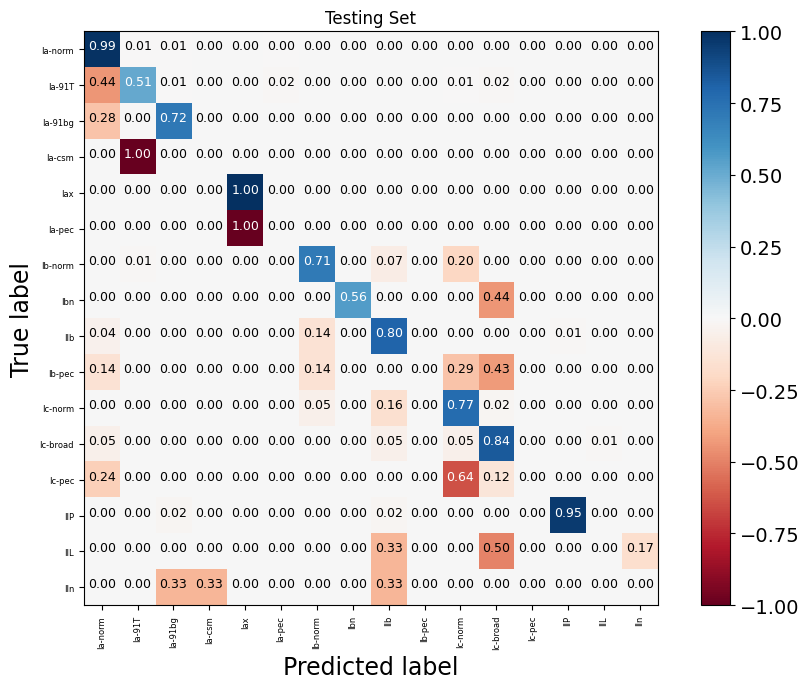

In [20]:
plot_cm(CMtst, SN_Stypes_str, "Testing Set", normalize=True)

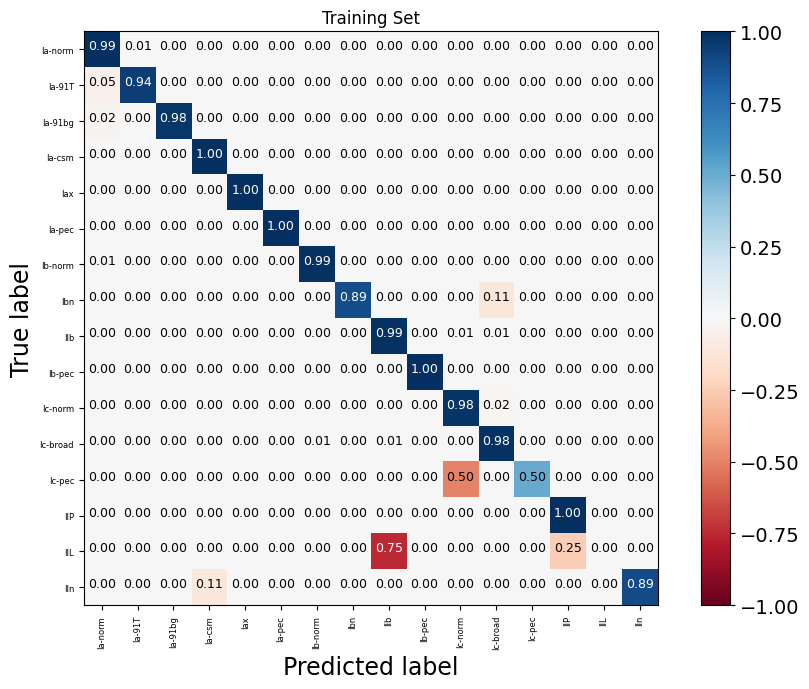

In [21]:
plot_cm(CMtrn, SN_Stypes_str, "Training Set", normalize=True)

Training set confusion matrix looks great, but the testing set is not good.